In [1]:
# Data management code, scroll to next cell for analysis
# Data management code, scroll to next cell for analysis
import pandas as pd
from pandas import Series,DataFrame

# BLS dataset for labor participation
# http://www.bls.gov/lau/staadata.zip
bls_file = pd.ExcelFile('staadata.xlsx')
# Parse the first sheet of the excel file and set as DataFrame
header = ['FIPS Code', 'State', 'Year', 'Civilian non-institutional population',
           'Civilian labor force Total', 'CLF Percent of population', 'CLF Employment Total',
           'CLF Employment Percent of population', 'CLF Unemployment Total',
           'CLF Unemployment Rate'
          ]
bls = bls_file.parse('Sheet1', skiprows=7, names=header)
bls12 = bls[bls.Year == 2012]
bls12 = bls12[['State','CLF Employment Percent of population','CLF Unemployment Rate']]
bls12['CLF Employment Percent of population'] = pd.to_numeric(bls12['CLF Employment Percent of population'])
bls12['CLF Unemployment Rate'] = pd.to_numeric(bls12['CLF Unemployment Rate'])
bls12.set_index('State')

# 2012 Election data to determine if a state is "red" or "blue"
# http://www.fec.gov/pubrec/fe2012/federalelections2012.shtml
pres_file = pd.ExcelFile('2012pres.xls')
pres = pres_file.parse('2012 Pres General Results')
pres = pres.drop([1, 'FEC ID', 'STATE ABBREVIATION', 'GENERAL ELECTION DATE'], axis=1)
pres.rename(columns={'STATE': 'State',
                     'GENERAL %': 'PercentOfVote'}, inplace=True)
Dem = pres[pres['LAST NAME'] == 'Obama'].set_index('State')
Rep = pres[pres['LAST NAME'] == 'Romney'].set_index('State')
Dem_Rep = pd.DataFrame(Dem['PercentOfVote'] - Rep['PercentOfVote'])
Dem_Rep.rename(columns={'PercentOfVote': 'Percent Obama Over Romney'}, inplace=True)
Dem_Rep.reset_index(level=0, inplace=True)

winner = pres[pres['WINNER INDICATOR'] == 'W']
winner.rename(columns={'LAST NAME': 'Winner'}, inplace=True)
winner = winner[['State','Winner', 'PercentOfVote']]
data = pd.merge(Dem_Rep, winner, left_on='State', right_on='State')
data = data.drop_duplicates('State', keep='first')


# Load income per capita as response variable
# https://en.wikipedia.org/wiki/List_of_U.S._states_by_income
income = pd.read_csv('per_capita_income.csv', low_memory=False)
income.rename(columns={'Per capita\nincome': 'IncomePerCapita'}, inplace=True)
income = income[[1, 2]]
income.set_index('State')
income['IncomePerCapita'] = income['IncomePerCapita'].apply(
    lambda x: x.replace('$', '').replace(',', ''))
income['IncomePerCapita'] = pd.to_numeric(income['IncomePerCapita'])

# Load 2012 SAT score average
# http://www.ipsr.ku.edu/ksdata/ksah/education/
sat_2012 = pd.read_csv('avg_SAT_2012.csv', low_memory=False)
sat_2012 = sat_2012[['State', 'Combined']]
sat_2012.rename(columns={'Combined': 'avg_SAT_2012'}, inplace=True)
sat_2012['avg_SAT_2012'] = pd.to_numeric(sat_2012['avg_SAT_2012'])
sat_2012.set_index('State')

# Merge data sets
data = pd.merge(data, bls12, left_on='State', right_on='State')
data = pd.merge(data, income, left_on='State', right_on='State')
data = pd.merge(data, sat_2012, left_on='State', right_on='State')

data.rename(columns={'CLF Employment Percent of population': 'Labor Participation',
                    'CLF Unemployment Rate': 'Unemployment2012'}, inplace=True)
data['Percent Obama Over Romney'] = pd.to_numeric(data['Percent Obama Over Romney'])
data['Labor Participation'] = pd.to_numeric(data['Labor Participation'])
data['Unemployment2012'] = pd.to_numeric(data['Unemployment2012'])

# 2012 crime data
# http://www.ucrdatatool.gov/Search/Crime/State/RunCrimeOneYearofData.cfm
crime = pd.read_csv('CrimeOneYearofData2012.csv', low_memory=False)
crime = crime[['State', 'Violent Crime rate', 'Property crime rate']]
crime['Violent Crime rate'] = pd.to_numeric(crime['Violent Crime rate'])
crime['Property crime rate'] = pd.to_numeric(crime['Property crime rate'])
data = pd.merge(data, crime, left_on='State', right_on='State')

data_clean = data.copy()
data_clean.head()

/home/titan/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,State,Percent Obama Over Romney,Winner,PercentOfVote,Labor Participation,Unemployment2012,IncomePerCapita,avg_SAT_2012,Violent Crime rate,Property crime rate
0,Alabama,-0.221868,Romney,0.605458,53.4,8.0,23606,1608,449.9,3502.2
1,Alaska,-0.139889,Romney,0.548016,63.4,7.1,33062,1495,603.2,2739.4
2,Arizona,-0.090648,Romney,0.536545,55.5,8.3,25715,1551,428.9,3539.2
3,Arkansas,-0.236879,Romney,0.605669,54.8,7.6,22883,1697,469.1,3660.1
4,California,0.231186,Obama,0.602390,56.6,10.4,30441,1505,423.1,2758.7


In [2]:
explanatory_vars = data_clean[['Labor Participation','Unemployment2012',
                               'IncomePerCapita','avg_SAT_2012',
                               'Violent Crime rate','Property crime rate']]
targets = data_clean.Winner

from sklearn.cross_validation import train_test_split
expla_train, expla_test, tar_train, tar_test = train_test_split(explanatory_vars,
                                                                targets, test_size=.4)
print('Training set: {0}. Testing set: {1}'.format(expla_train.shape, expla_test.shape) )

Training set: (30, 6). Testing set: (21, 6)


In [3]:
#Build model on training data
from sklearn.ensemble import RandomForestClassifier

classifier=RandomForestClassifier(n_estimators=25)
classifier=classifier.fit(expla_train,tar_train)

predictions=classifier.predict(expla_test)

import sklearn.metrics
print(sklearn.metrics.confusion_matrix(tar_test,predictions))
sklearn.metrics.accuracy_score(tar_test, predictions)

[[ 5  2]
 [ 3 11]]


0.76190476190476186

In [4]:
# fit an Extra Trees model to the data
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(expla_train, tar_train)
# display the relative importance of each attribute
print(model.feature_importances_)

[ 0.07652559  0.09407533  0.30495741  0.18910925  0.08792912  0.24740329]


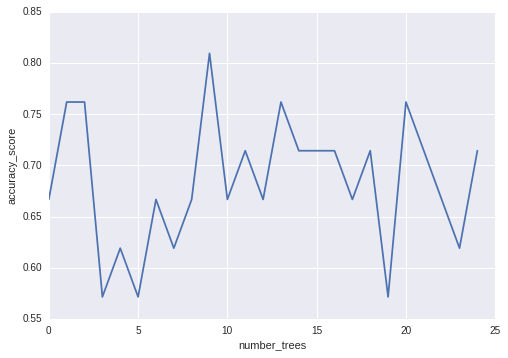

In [5]:
"""
Running a different number of trees and see the effect
 of that on the accuracy of the prediction
"""
import numpy as np

trees=range(25)
accuracy=np.zeros(25)

for idx in range(len(trees)):
   classifier = RandomForestClassifier(n_estimators=idx + 1)
   classifier = classifier.fit(expla_train,tar_train)
   predictions = classifier.predict(expla_test)
   accuracy[idx]=sklearn.metrics.accuracy_score(tar_test, predictions)
   
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sb
plt.cla()
plt.plot(trees, accuracy)
plt.xlabel('number_trees')
plt.ylabel('accuracy_score')

Graph shows highest accuracy with 9 trees, but it's decent at 2.